In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"
import numpy as np
import h5py
import cv2
import os, sys
import json
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import *
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
import imageio
from celluloid import Camera # getting the camera
from IPython.display import HTML
%load_ext autoreload
%autoreload 2

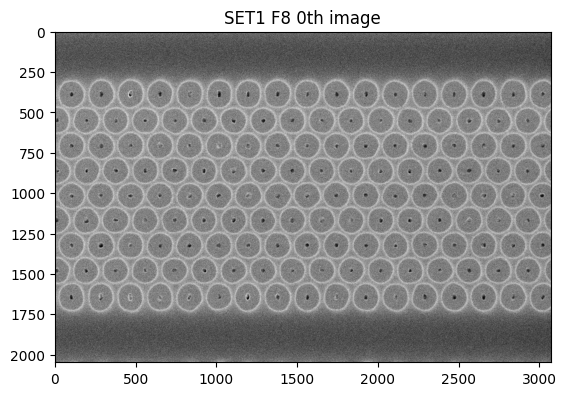

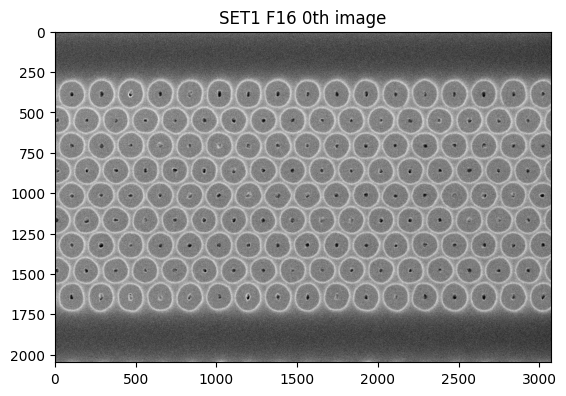

In [26]:
F8_1_img = cv2.imread("../data/Samsung_tmp_dataset/Samsung_SNU/[SET 1]/F8/1_F8.png",cv2.IMREAD_GRAYSCALE)
plt.title("SET1 F8 0th image")
plt.imshow(F8_1_img,cmap='gray')
plt.pause(0.01)
F16_1_img = cv2.imread("../data/Samsung_tmp_dataset/Samsung_SNU/[SET 1]/F16/1_F16.png",cv2.IMREAD_GRAYSCALE)
plt.title("SET1 F16 0th image")
plt.imshow(F16_1_img,cmap='gray')
plt.pause(0.01)

# CD measurement code

In [3]:
img_dict = np.load("./intermediate_result/segmentation_img_F08_v2.npy",allow_pickle=True).item()

with open(f'./hole_info_F08_v2.txt', 'r') as f:
    hole_info = json.load(f)

center :  144 146


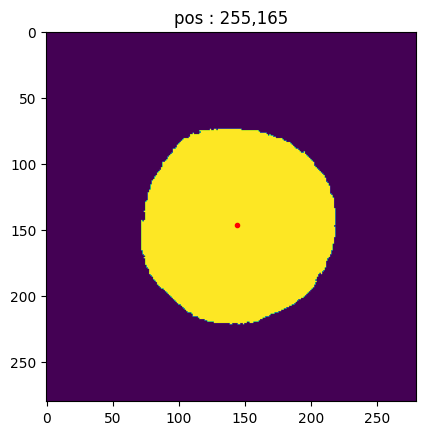

center :  146 147


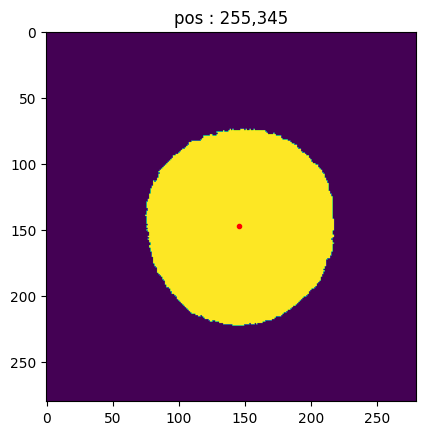

center :  144 147


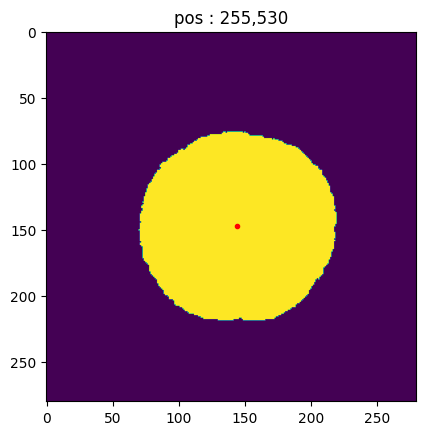

center :  146 148


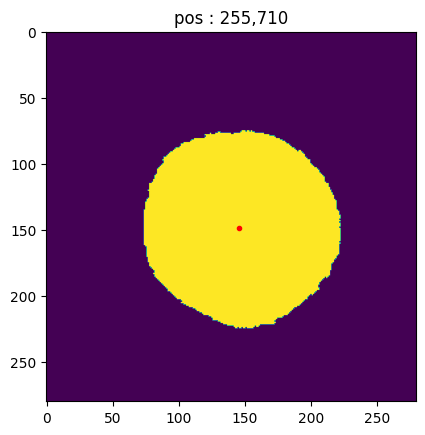

center :  143 145


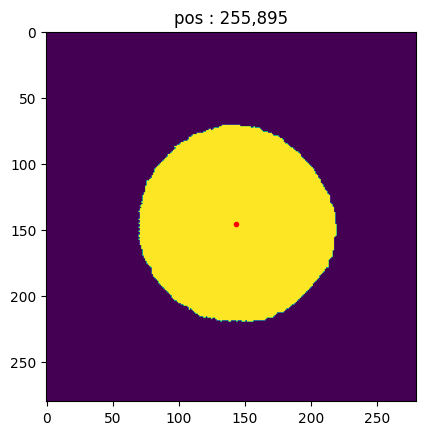

center :  145 148


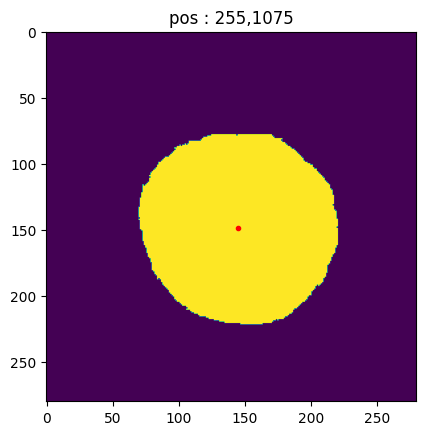

center :  148 147


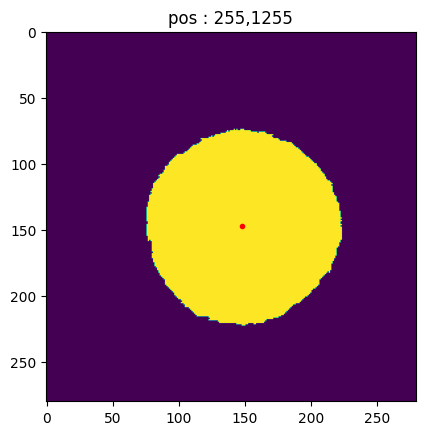

center :  148 146


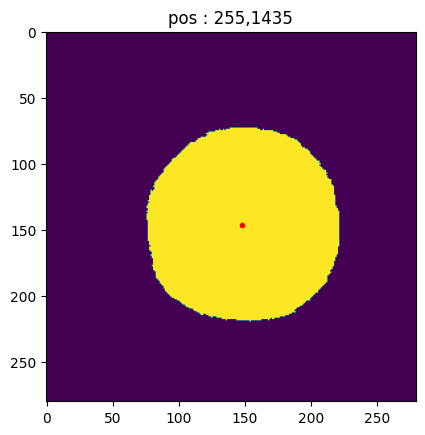

center :  145 146


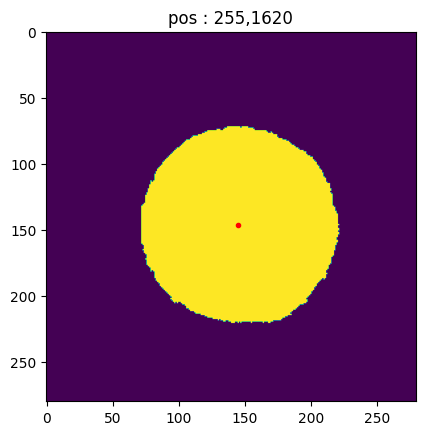

center :  141 146


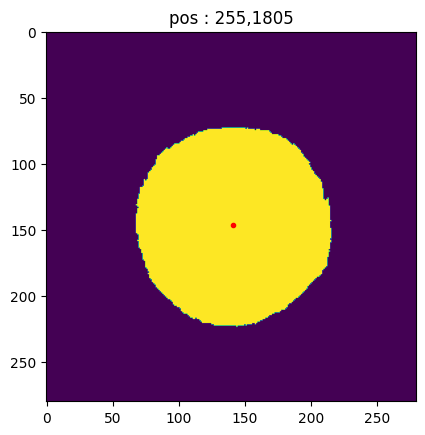

center :  145 146


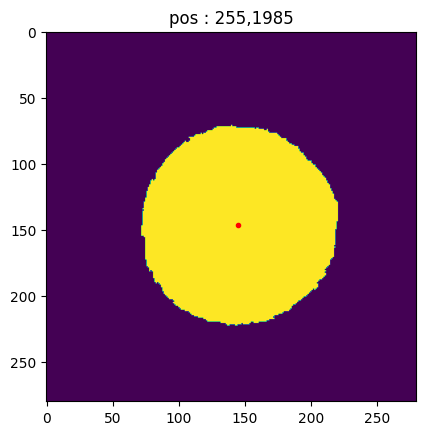

center :  145 149


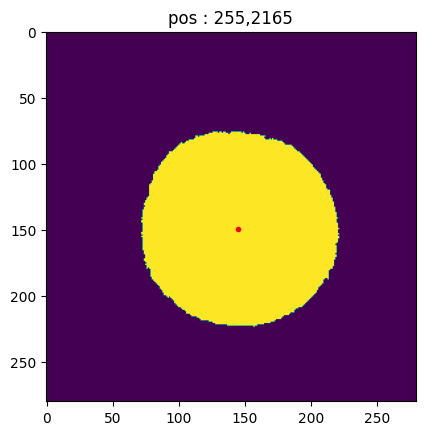

center :  142 148


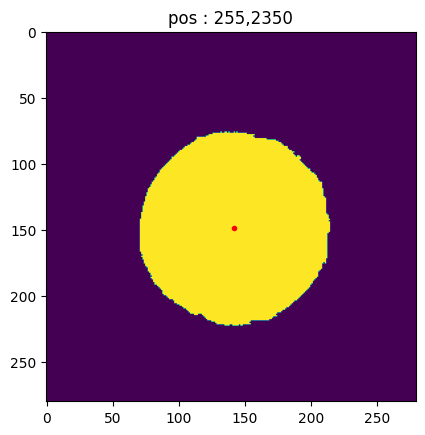

center :  147 148


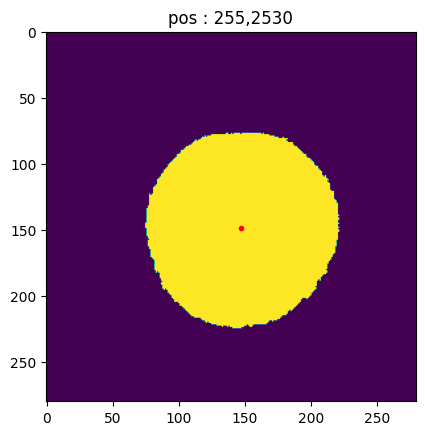

center :  147 149


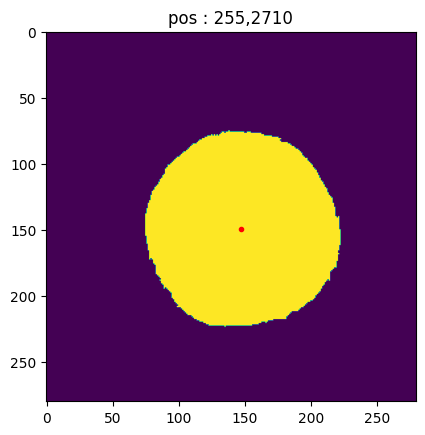

center :  146 148


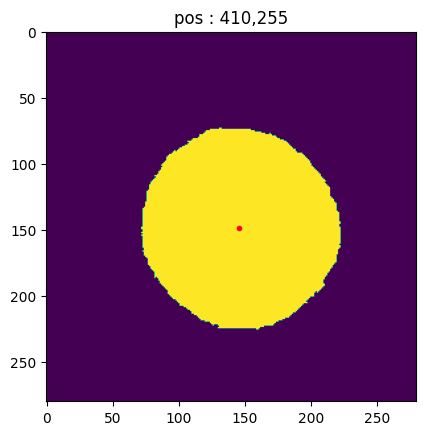

center :  148 146


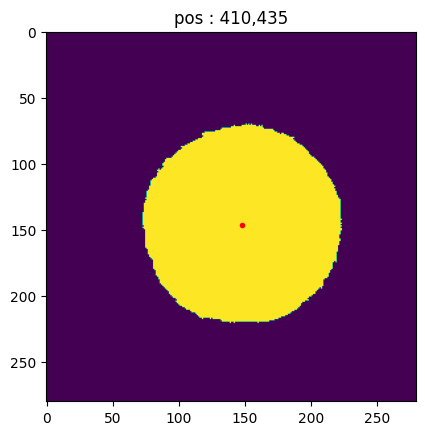

center :  145 146


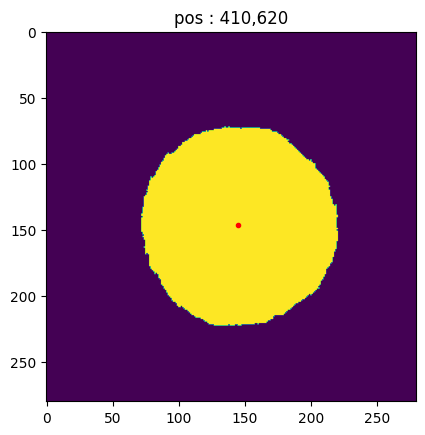

center :  147 148


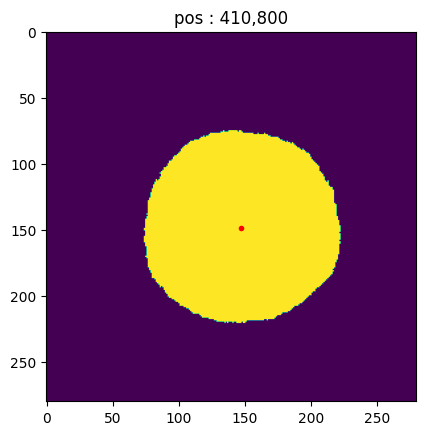

center :  145 150


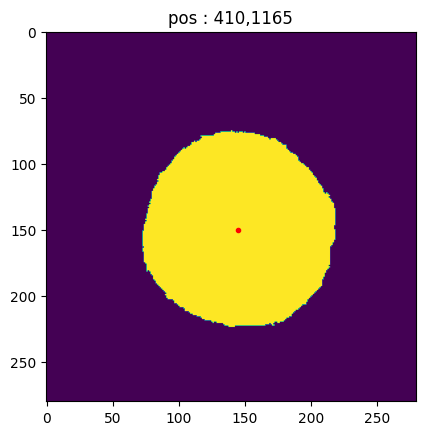

center :  148 147


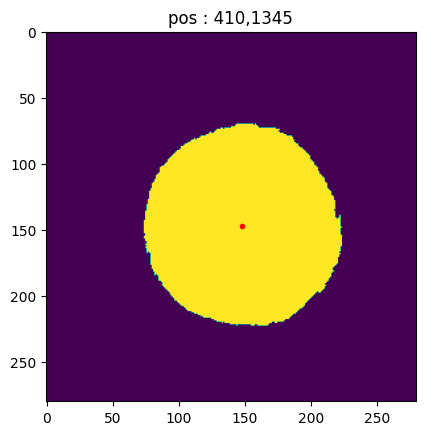

center :  144 147


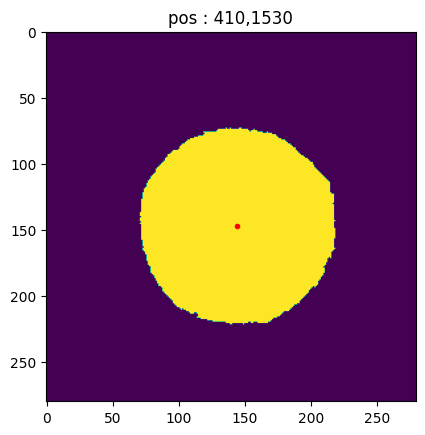

center :  147 150


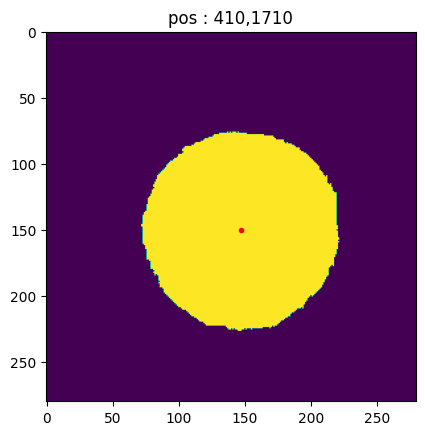

center :  148 148


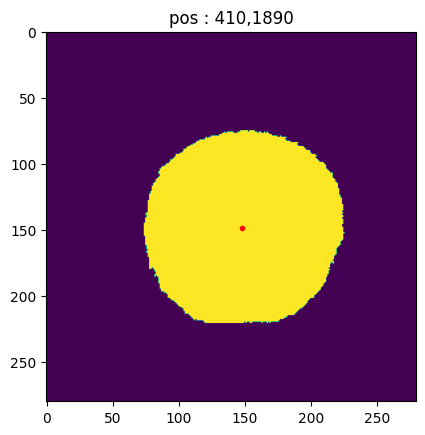

center :  143 147


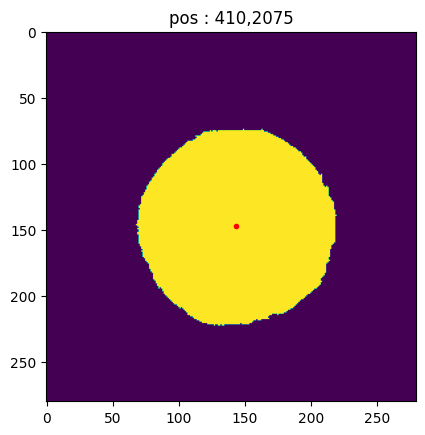

center :  146 147


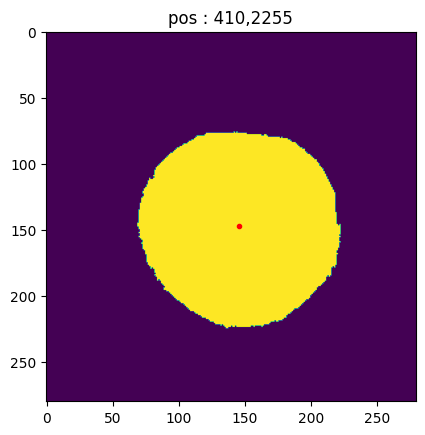

center :  143 147


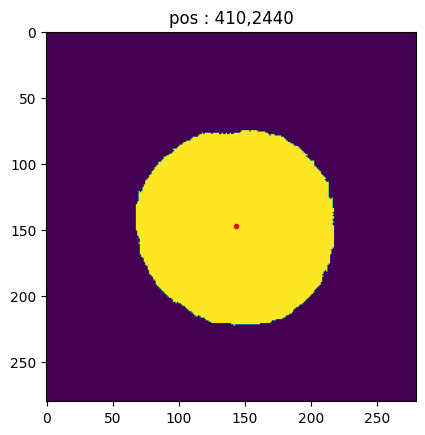

center :  147 148


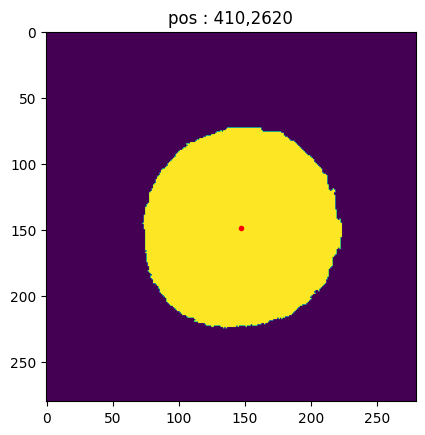

center :  143 148


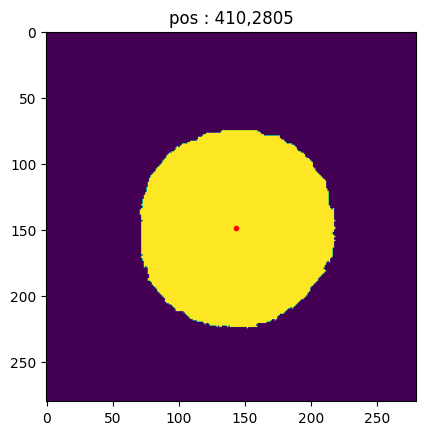

center :  148 147


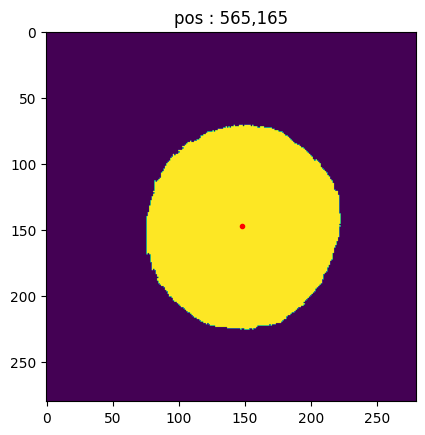

center :  147 147


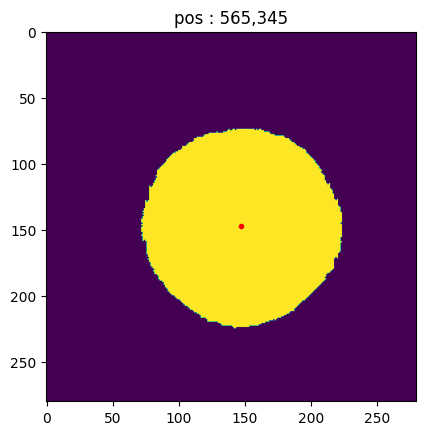

center :  145 145


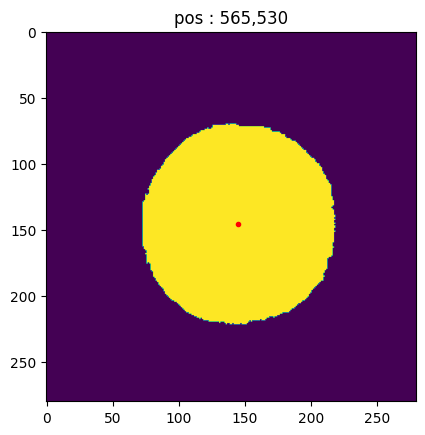

center :  145 146


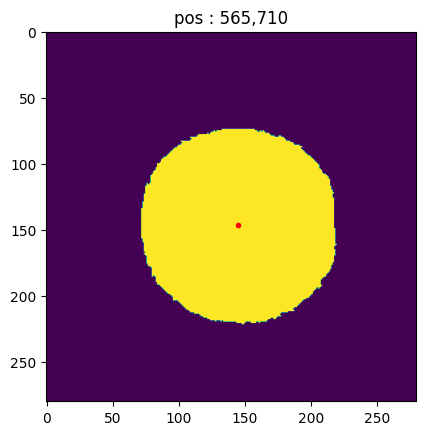

center :  141 147


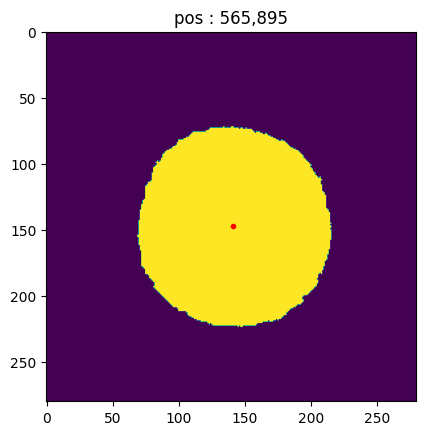

center :  143 147


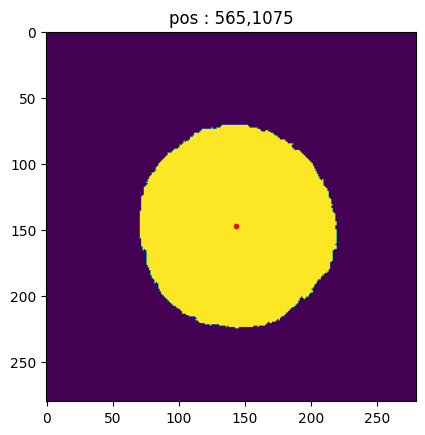

center :  147 146


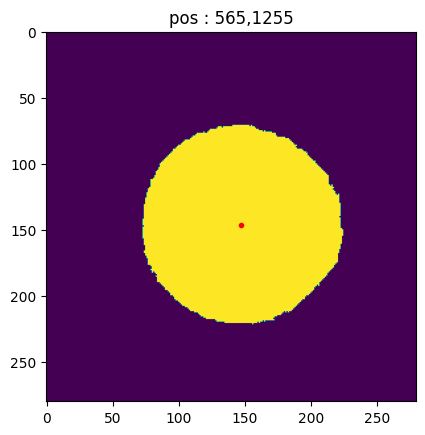

center :  149 148


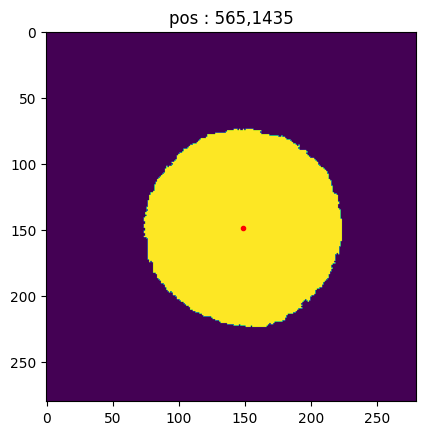

center :  145 148


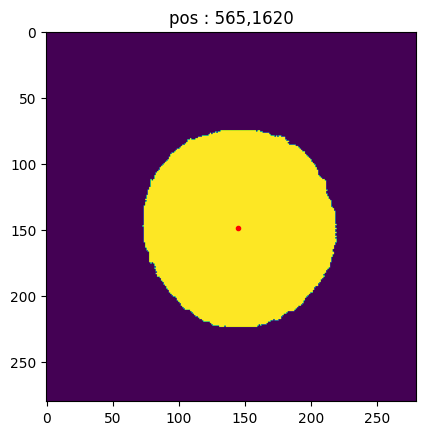

center :  142 148


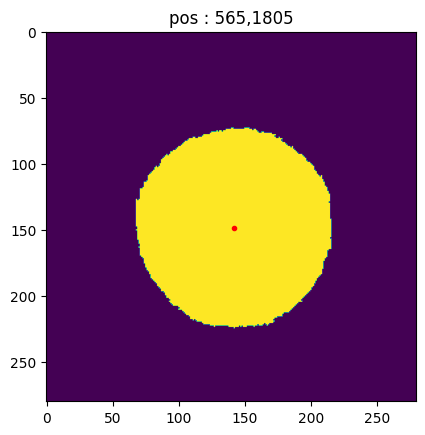

center :  144 149


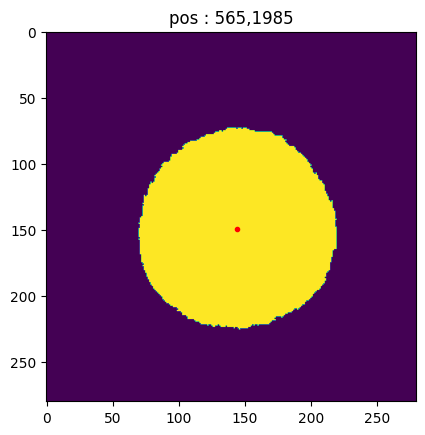

center :  146 150


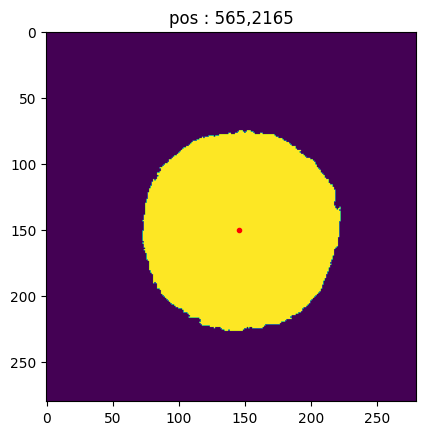

center :  143 147


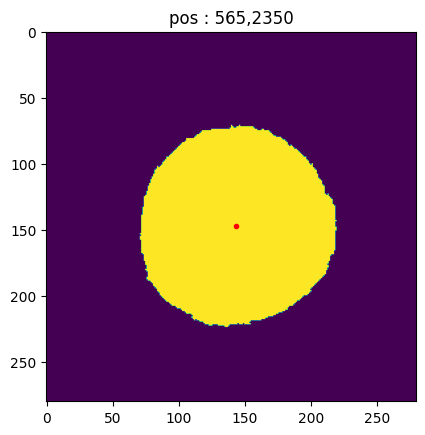

center :  146 146


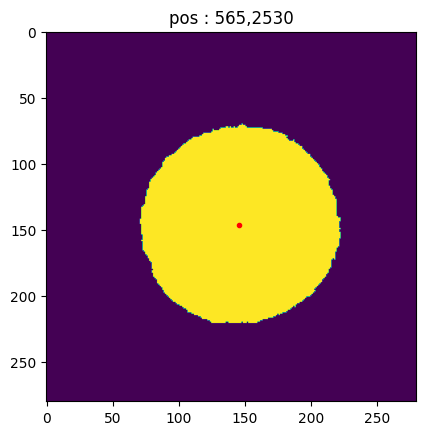

center :  147 146


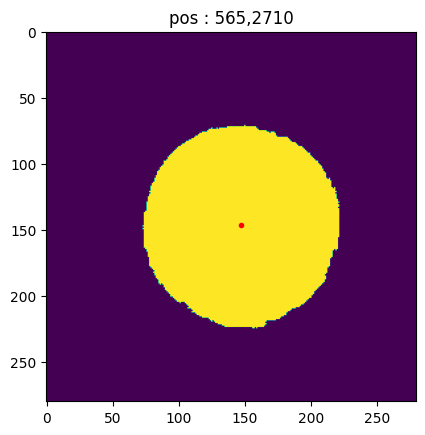

center :  144 144


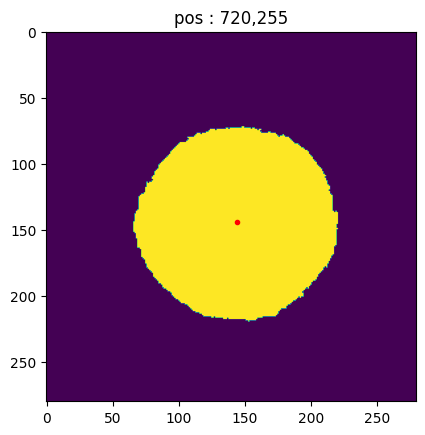

center :  148 147


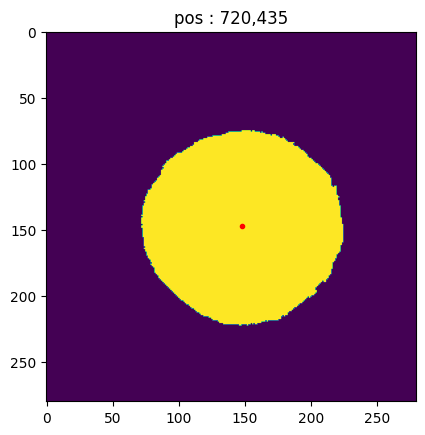

center :  143 146


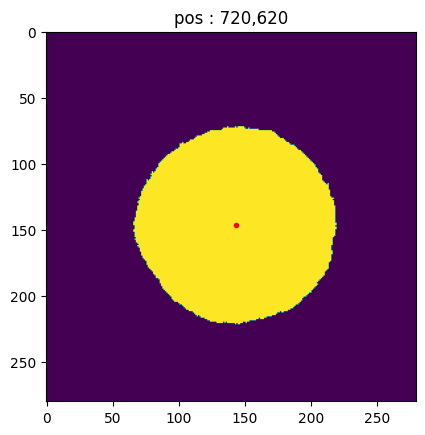

center :  149 148


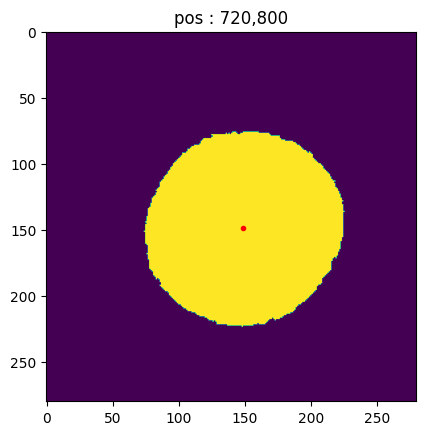

center :  148 147


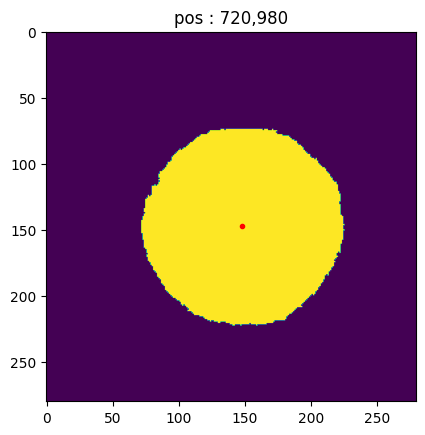

center :  147 146


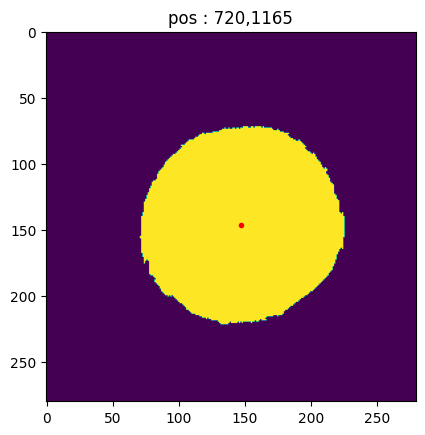

center :  148 148


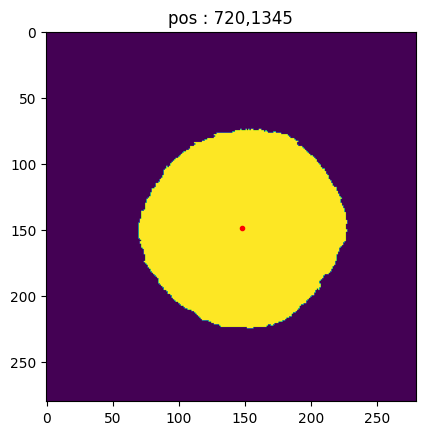

center :  145 146


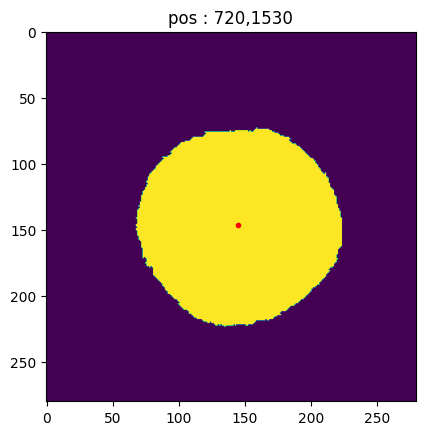

center :  145 144


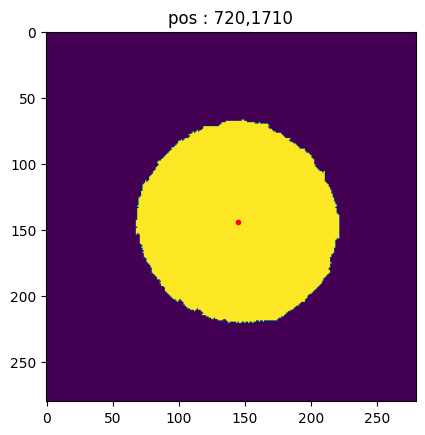

center :  149 144


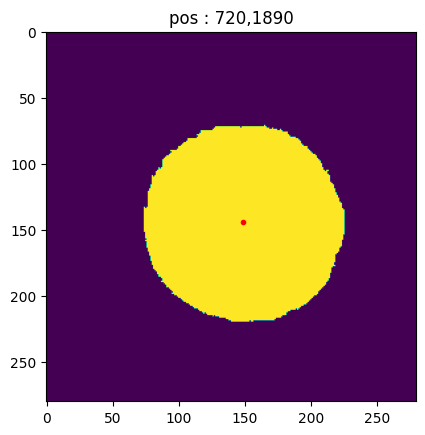

center :  145 147


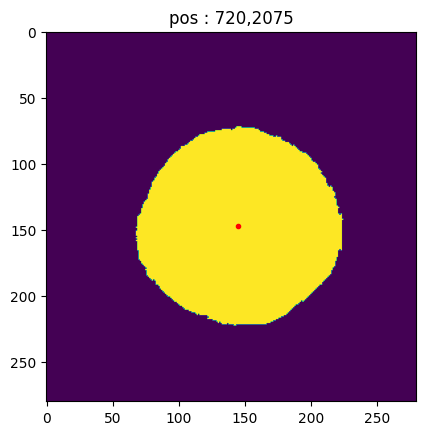

center :  146 146


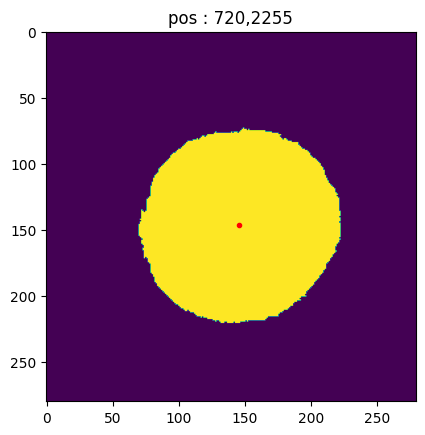

center :  144 146


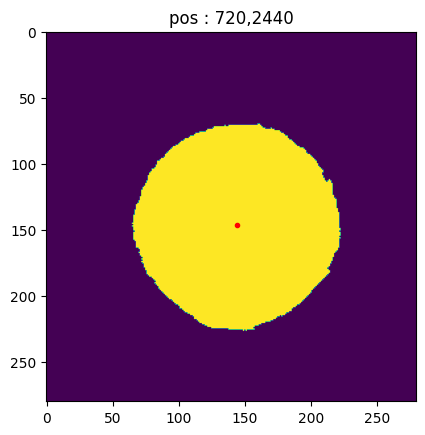

center :  146 145


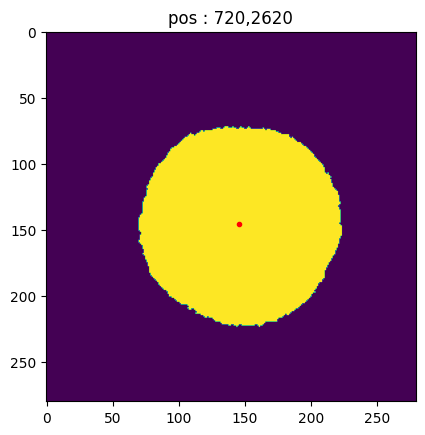

center :  142 145


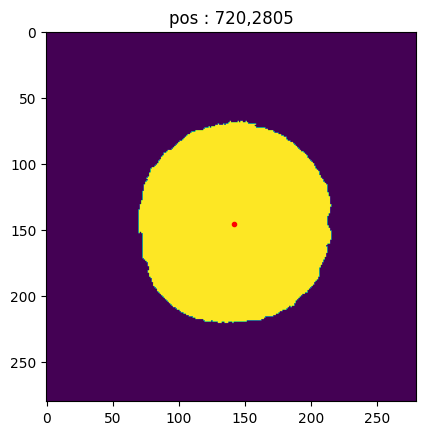

center :  145 150


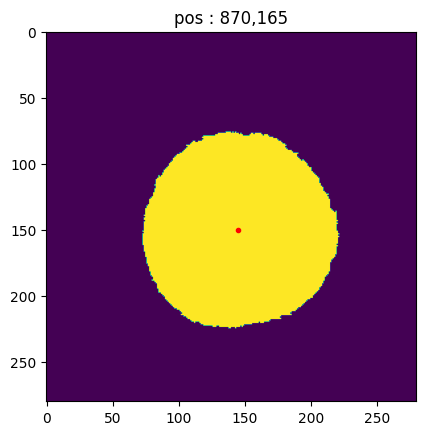

center :  145 148


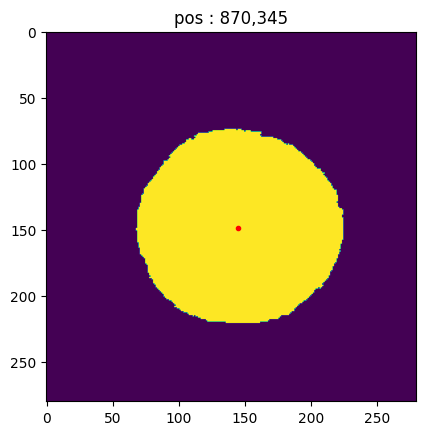

center :  144 149


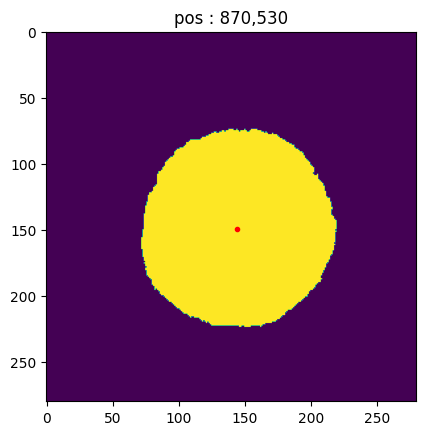

center :  146 149


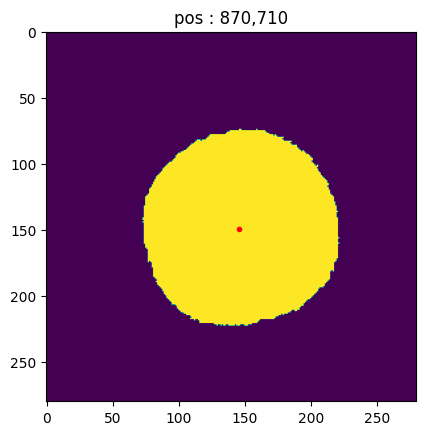

center :  141 148


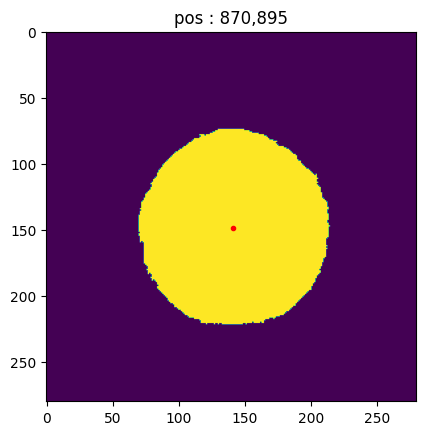

center :  147 149


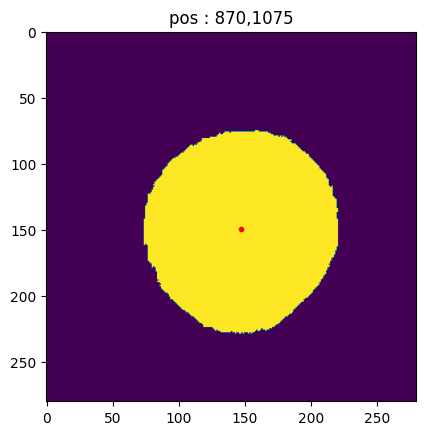

center :  146 150


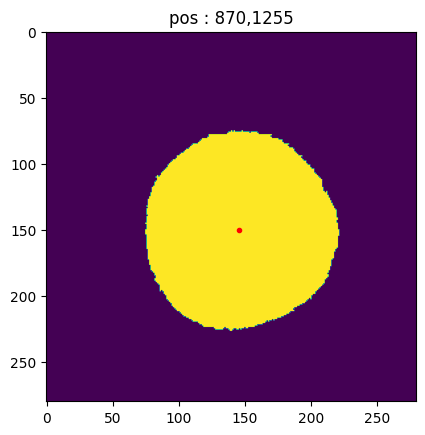

center :  149 149


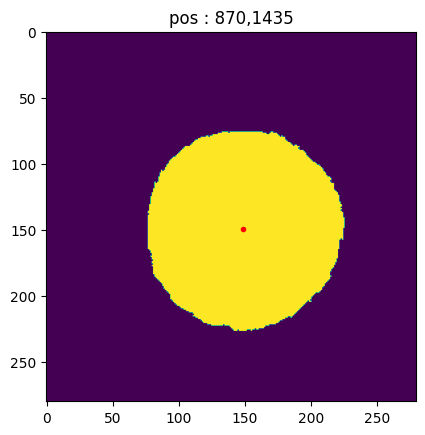

center :  146 149


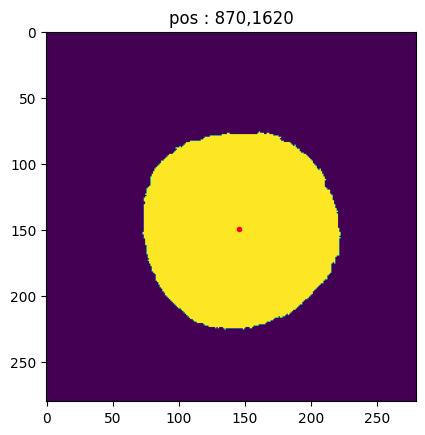

center :  141 149


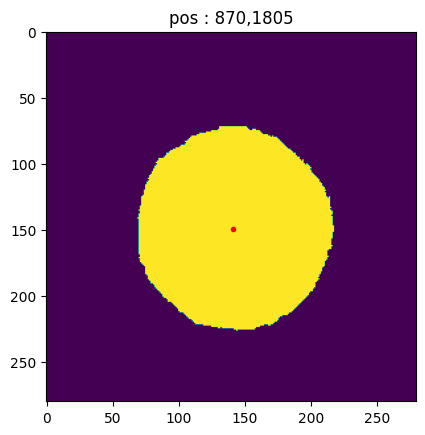

center :  144 150


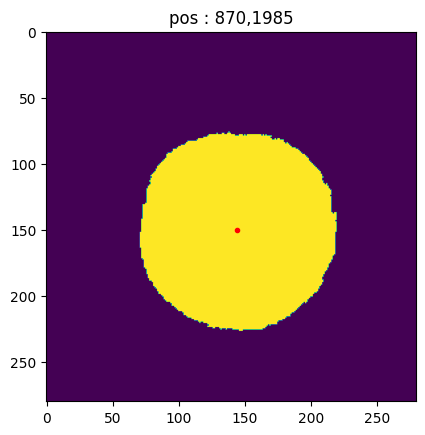

center :  146 150


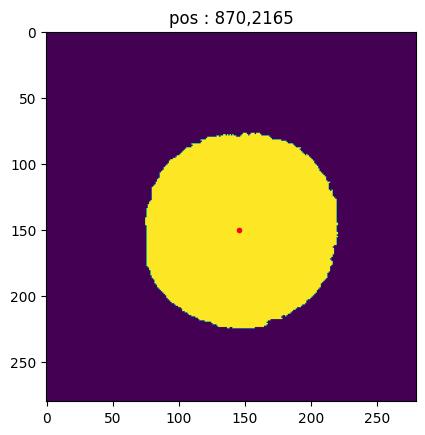

center :  142 148


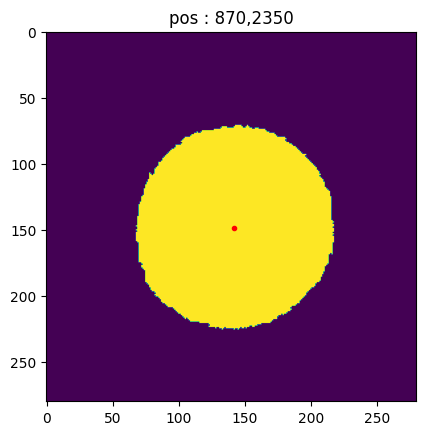

center :  145 149


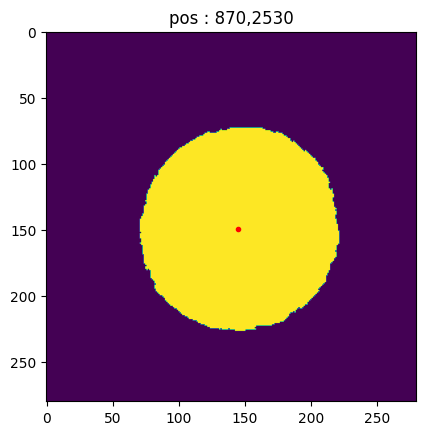

center :  150 149


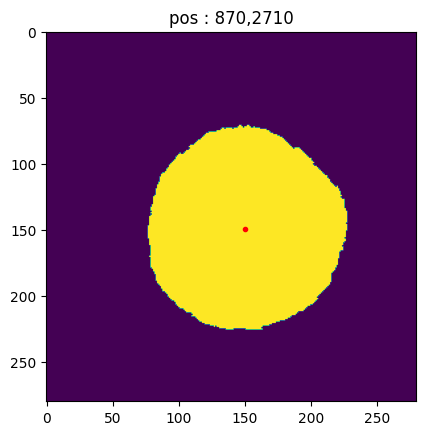

center :  145 148


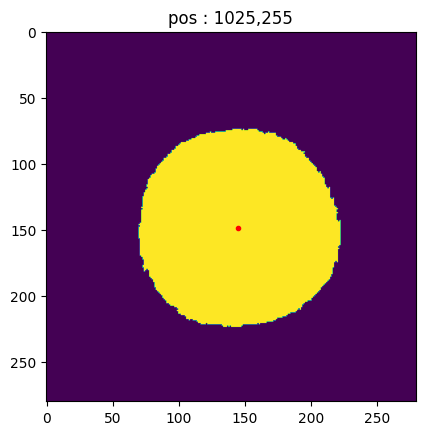

center :  149 149


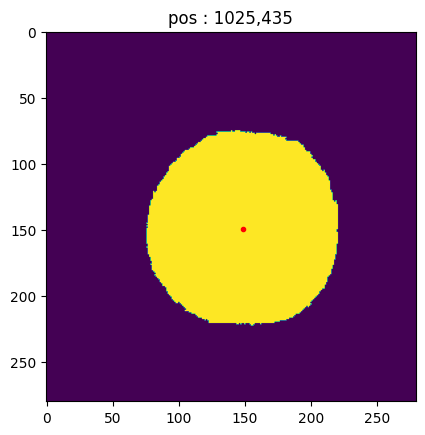

center :  146 151


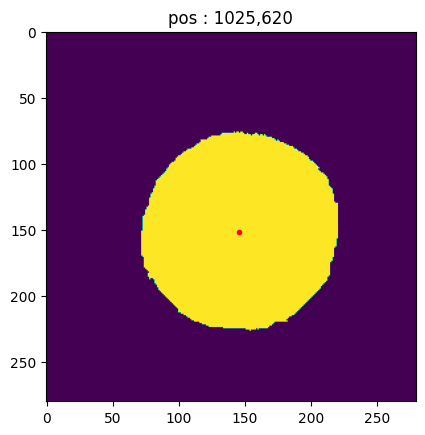

center :  146 149


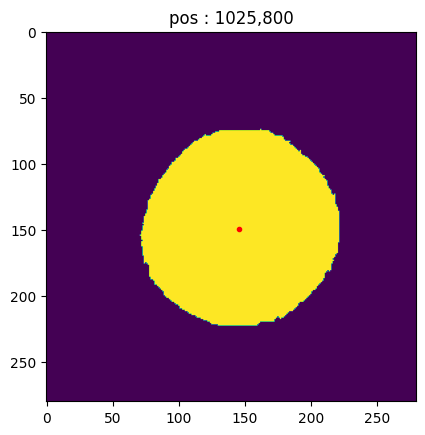

center :  149 150


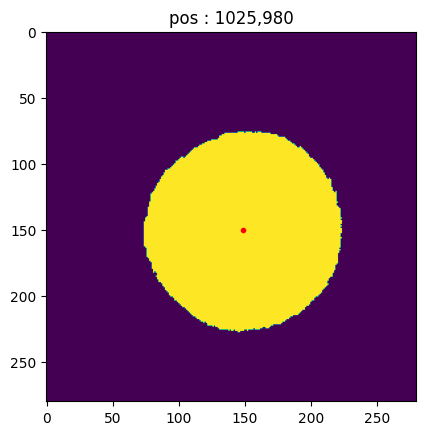

center :  145 148


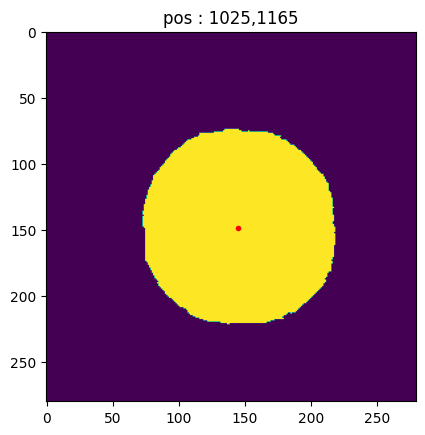

center :  147 149


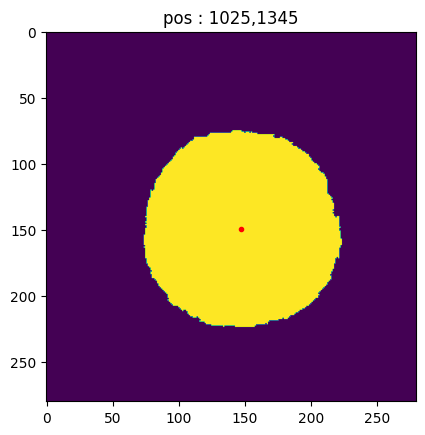

center :  143 148


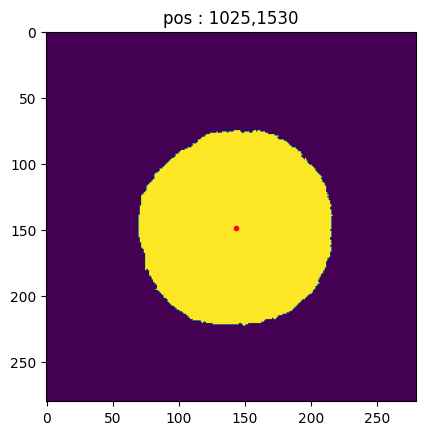

center :  146 148


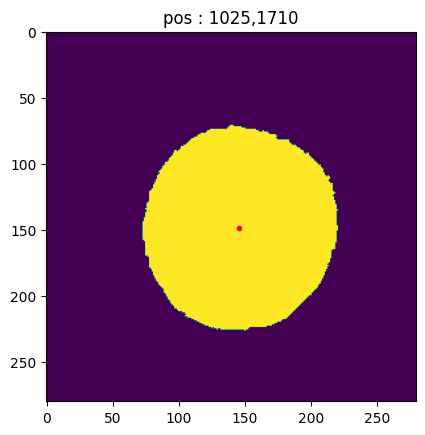

center :  150 149


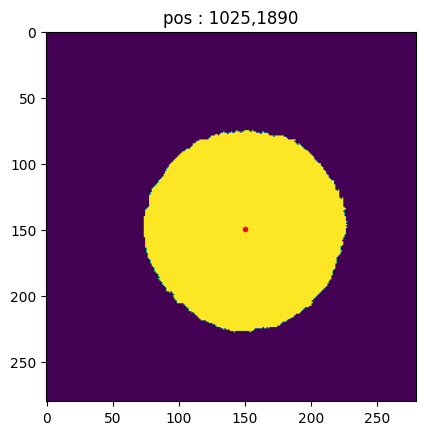

center :  145 150


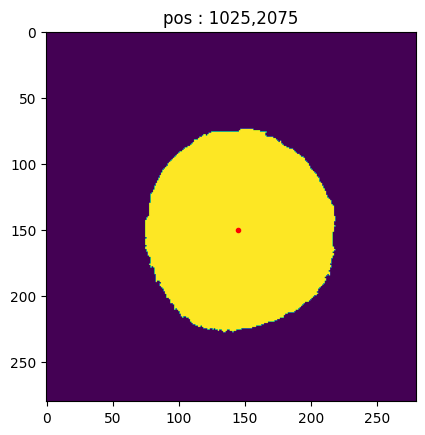

center :  147 146


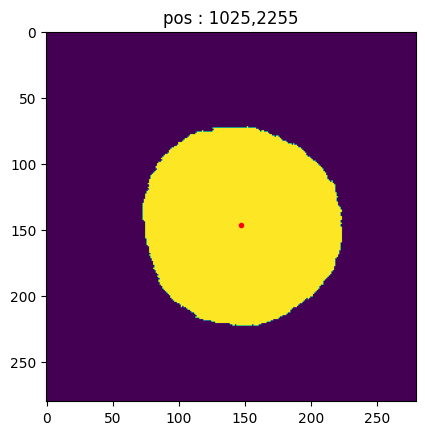

center :  144 149


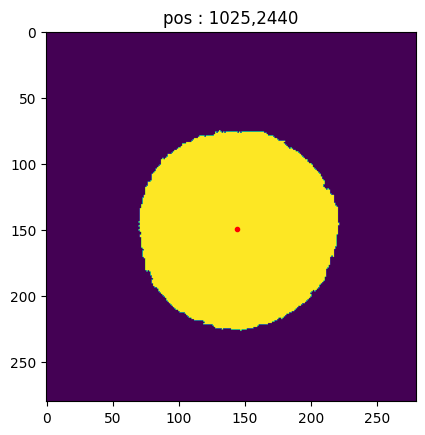

center :  146 147


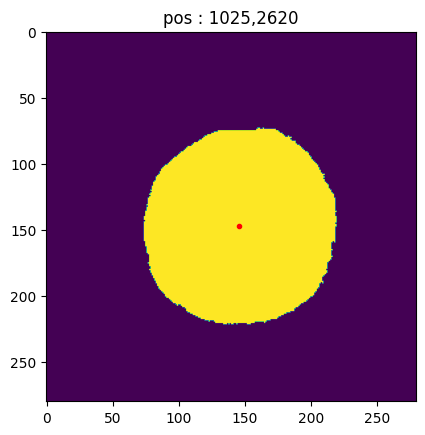

center :  143 149


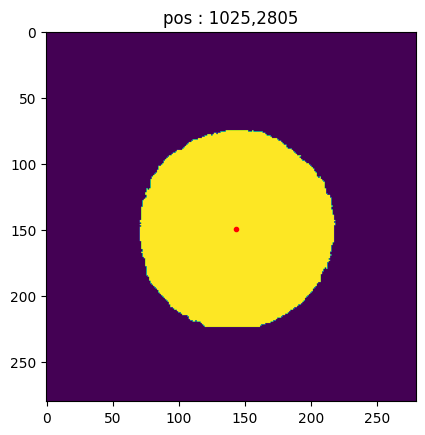

center :  142 145


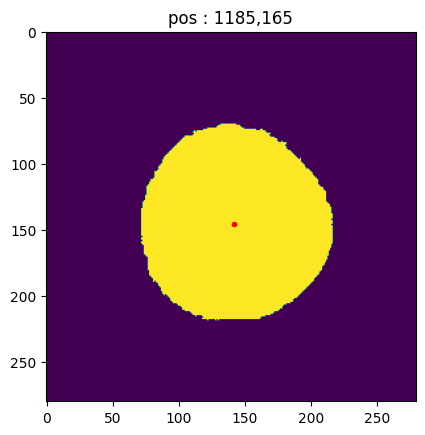

center :  146 145


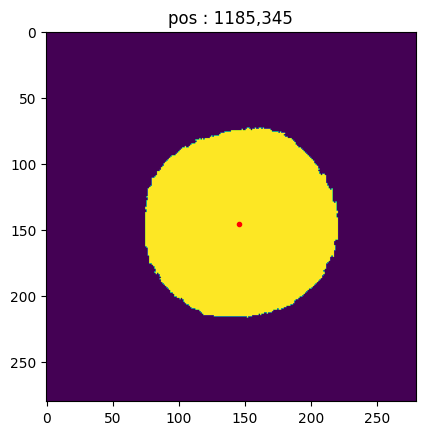

center :  142 144


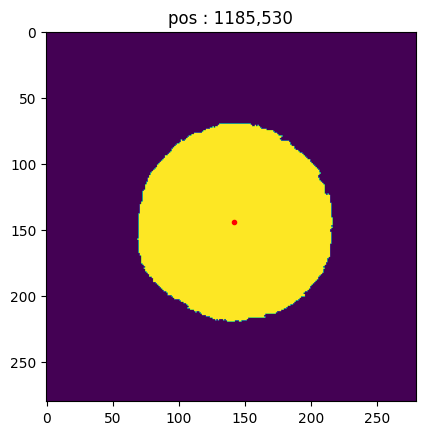

center :  145 144


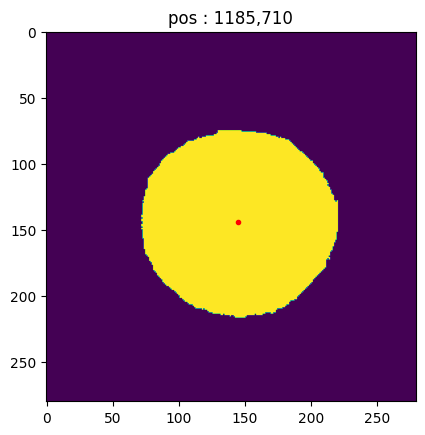

center :  144 144


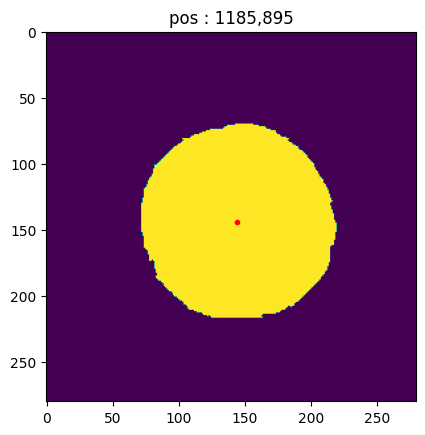

center :  145 145


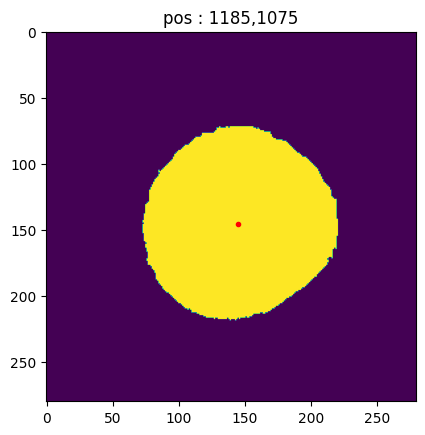

center :  147 145


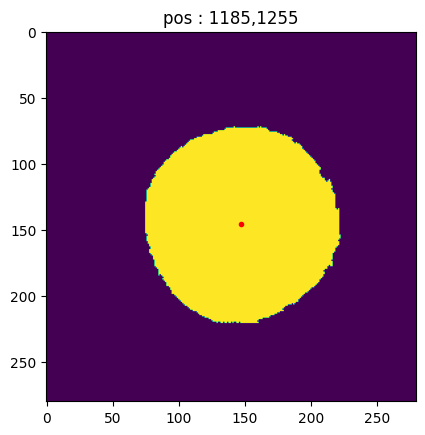

center :  148 145


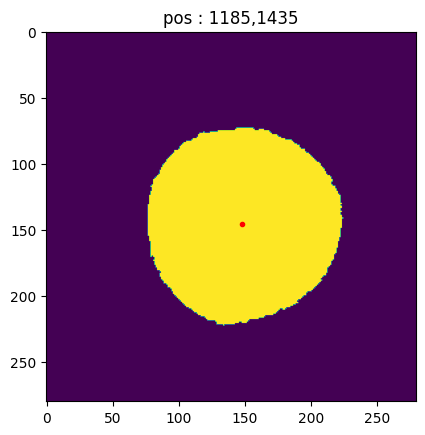

center :  146 143


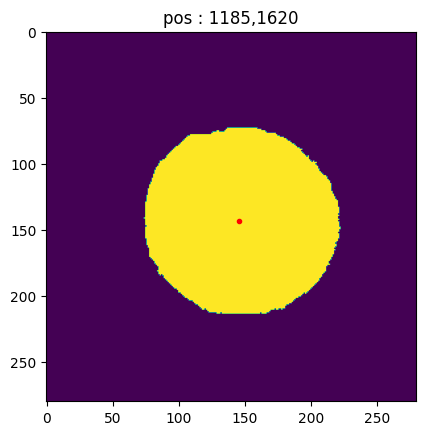

center :  143 143


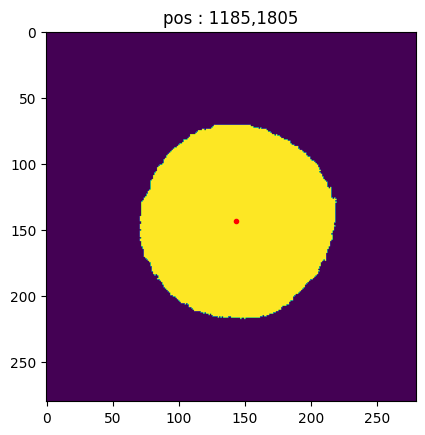

center :  145 145


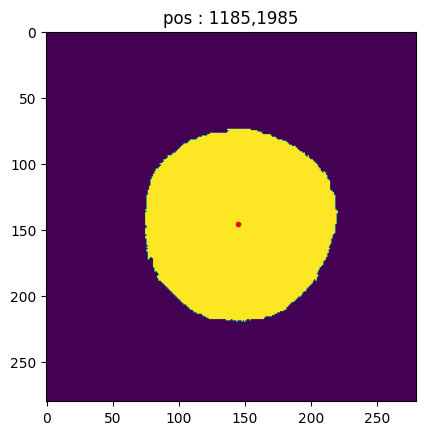

center :  146 146


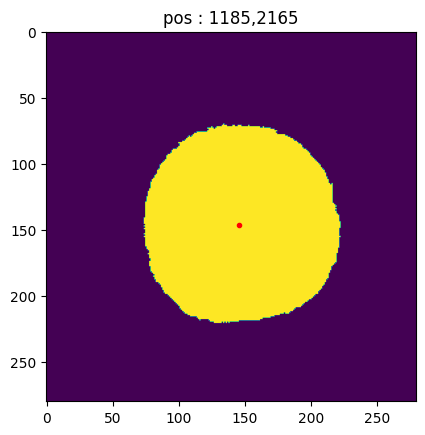

center :  146 142


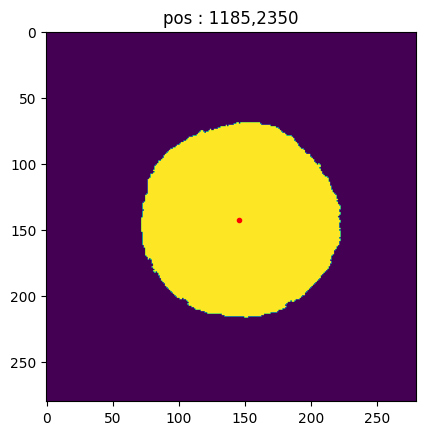

center :  145 144


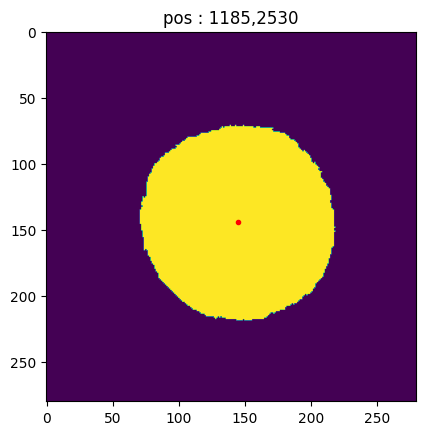

center :  146 144


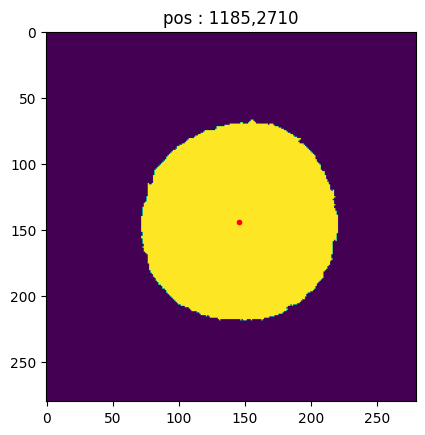

SET01, F08 0 - Min/Max (len : 104) CD :                 145.2768 ~ 155.0194


In [4]:
print_img = True
pad = 140
CD_dict = {}
for set_num in img_dict.keys():
    CD_dict[set_num] = {}
    for f_num in img_dict[set_num].keys():
        CD_dict[set_num][f_num] = {}
        f_num = f_num[:3]
        for idx,img in enumerate(img_dict[set_num][f_num]):
            CD_dict[set_num][f_num][idx] = {"min_CD" : [], "max_CD" : []}
            img_hole_info = hole_info[set_num][f_num][idx]
            
            # make image patch
            for i,j in img_hole_info:
                # crop image patch
                pos = {'r_start' : i-pad, 'r_end' : i+pad, 'c_start' : j-pad, 'c_end' : j+pad}
                for key,item in pos.items():
                    if item < 0:
                        pos[key] = 0
                img_patch = img[pos['r_start']:pos['r_end'],pos['c_start']:pos['c_end']].copy()
                if img_patch.shape != (pad*2,pad*2):
                    continue
                
                # leave only circle imagein patch 
                circle_val = img[i,j]
                img_patch[img_patch != circle_val] = 0
                
                (cX,cY), circle_with_marker = find_center(img_patch)
                
                if print_img is True:
                    print("center : ",cX,cY)
                    plt.title(f"pos : {i},{j}")
                    plt.imshow(img_patch)
                    plt.scatter(cX,cY,color='r',marker='.')
                    plt.pause(0.01)
                
                # find min/max CD
                min_CD,max_CD = None, None
                for angle in range(0,180):
                    measured_CD = measure_CD(img_patch,cX,cY,angle,debug=False)
                    if measured_CD is None:
                        break
                    # print(f"CD is {CD}")
                    if min_CD is None or min_CD > measured_CD:
                        min_CD = measured_CD
                    if max_CD is None or max_CD < measured_CD:
                        max_CD = measured_CD
                if measured_CD is None:
                    print(f"{set_num}, {f_num} {idx} cannot get CD measurement")
                    continue
                CD_dict[set_num][f_num][idx]['min_CD'].append(min_CD)
                CD_dict[set_num][f_num][idx]['max_CD'].append(max_CD)
            CD_dict[set_num][f_num][idx]['avg_min_CD'] = np.mean(CD_dict[set_num][f_num][idx]['min_CD'])
            CD_dict[set_num][f_num][idx]['avg_max_CD'] = np.mean(CD_dict[set_num][f_num][idx]['max_CD'])
            len_CD_measurement = len(CD_dict[set_num][f_num][idx]['min_CD'])
            CD_dict[set_num][f_num][idx]['length'] = len_CD_measurement
            print(f"{set_num}, {f_num} {idx} - Min/Max (len : {len_CD_measurement}) CD : \
                {CD_dict[set_num][f_num][idx]['avg_min_CD']:.4f} ~ {CD_dict[set_num][f_num][idx]['avg_max_CD']:.4f}")
            break
        break
    break

In [5]:
print(f"{set_num} {f_num} {idx}th image")
CD_dict[set_num][f_num][idx]['avg_min_CD'], CD_dict[set_num][f_num][idx]['avg_max_CD'], 

SET01 F08 0th image


(145.27683134080146, 155.01944776659715)

# Visualize code

In [ ]:
print_img = True
for set_num in img_dict.keys():
    for f_num in img_dict[set_num].keys():
        if f_num == 'F08' :
            continue
        f_num = f_num[:3]
        for idx,img in enumerate(img_dict[set_num][f_num]):
            img_hole_info = hole_info[set_num][f_num][idx]
            plt.title(f"{set_num} {f_num} {idx}th image")
            plt.imshow(img)
            for j,i in img_hole_info:
                plt.scatter(i,j, color='r', marker='.')
            plt.pause(0.01)
            if idx == 14 : 
                break
        break
    break

In [ ]:
cnt = 0 
raw_img_dict = np.load("./intermediate_result/denoised_img_F08_v2_img_dict.npy",allow_pickle=True).item()

raw_img = raw_img_dict['SET01']['F16'][14][0]
# plt.imshow(raw_img)

fig, ax = plt.subplots() # make it bigger
camera = Camera(fig)# the camera gets our figure
for j,i in img_hole_info:
    pad = 100
    # print(f"pos : {j},{i}")
    pos = {'r_start' : j-pad, 'r_end' : j+pad, 'c_start' : i-pad, 'c_end' : i+pad}
    for key,item in pos.items():
        if item < 0:
            pos[key] = 0
    img_patch = img[pos['r_start']:pos['r_end'],pos['c_start']:pos['c_end']]
    raw_img_patch = raw_img[pos['r_start']:pos['r_end'],pos['c_start']:pos['c_end']]
    # circle_val = img[j,i]
    # img_patch[img_patch != circle_val] = 0
    
    ax.imshow(raw_img_patch)
    camera.snap()
    cnt +=1
print("circle count : ",cnt)
animation = camera.animate()
HTML(animation.to_html5_video())

In [ ]:

index = 15
raw_img_dict = np.load("./intermediate_result/denoised_img_F08_v2_img_dict.npy",allow_pickle=True).item()
raw_img = raw_img_dict['SET01']['F16'][index][0]
img_dict = np.load("./intermediate_result/segmentation_img_F08_v2.npy",allow_pickle=True).item()
img = img_dict['SET01']['F16'][index]
img_hole_info = hole_info['SET01']['F16'][index]

# Visualize circle finding process

In [ ]:
from matplotlib.patches import Rectangle

from celluloid import Camera # getting the camera
from IPython.display import HTML

fig, ax = plt.subplots(2,1) # make it bigger
ax[0].set_title(f'SET01 F16 {index}')
camera = Camera(fig)# the camera gets our figure
for i,j in img_hole_info:

    # j += 10
    # print(f"pos : {i},{j}")

    pos = {'r_start' : i-pad, 'r_end' : i+pad, 'c_start' : j-pad, 'c_end' : j+pad}
    for key,item in pos.items():
        if item < 0:
            pos[key] = 0
    img_patch = img[pos['r_start']:pos['r_end'],pos['c_start']:pos['c_end']].copy()
    raw_img_patch = raw_img[pos['r_start']:pos['r_end'],pos['c_start']:pos['c_end']]
    circle_val = img[i,j]
    img_patch[img_patch != circle_val] = 0
    # print(img_patch.shape)
    
    # ax = plt.gca()
    # ax.subplot(121)
    ax[0].imshow(img,cmap='gray')
    rect = Rectangle((j-pad,i-pad),pad*2,pad*2,
                     linewidth=2,
                     edgecolor='cyan',
                     fill = False)
    ax[0].add_patch(rect)
    # ax.subplot(122)
    ax[1].imshow(img_patch)
    camera.snap()
    
    # measure CD
    
    
ax[0].imshow(img,cmap='gray')

ax[1].imshow(np.zeros((pad*2,pad*2)))
camera.snap()

animation = camera.animate()
HTML(animation.to_html5_video())
# plt.pause(0.01)
# plt.plot(img[i][j-pad:j+pad])


In [ ]:

(cX,cY), circle_with_marker = find_center(img_patch)
print("center : ",cX,cY)
plt.imshow(img_patch)
plt.scatter(cX,cY,color='r',marker='.')
min_CD,max_CD = None, None
for angle in range(0,180):
    measured_CD = measure_CD(img_patch,cX,cY,angle,debug=False)
    # print(f"CD is {CD}")
    if min_CD is None or min_CD > measured_CD:
        min_CD = measured_CD
    
    if max_CD is None or max_CD < measured_CD:
        max_CD = measured_CD
print(f"Min/Max CD : {min_CD:.4f} ~ {max_CD:.4f}")